In [150]:
import pandas as pd
import json
import folium
import requests
from bs4 import BeautifulSoup

import os


from ipywidgets import interact, fixed
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

## European unemployment

We obtained the data from [this eurostat page](http://ec.europa.eu/eurostat/data/database) navigating into the following directories hierarchy:

 - Tables by theme
 - Population and social conditions
 - Labour market
 - Employment and unemployment (Labour force survey)
 - LFS Main indicators
 - Unemployment - LFS adjusted series
 - Total unemployment rate

[Statistical description of the dataset](http://ec.europa.eu/eurostat/cache/metadata/en/tsdec450_esmsip.htm)

We check the data and remark that we have to split the first column.

In [151]:
euro = pd.read_csv('Homework3-data/european_unemployment.tsv',
                   sep='\t',
                   usecols=['age,unit,sex,geo\\time', '2016 '])
euro.head()

age,unit,sex,geo\time  2016 
0     TOTAL,PC_ACT,T,AT    6.0
1     TOTAL,PC_ACT,T,BE    7.8
2     TOTAL,PC_ACT,T,BG    7.6
3     TOTAL,PC_ACT,T,CY   13.0
4     TOTAL,PC_ACT,T,CZ    4.0

In [152]:
countries = pd.DataFrame(euro['age,unit,sex,geo\\time'].str.split(',', expand=True))
countries.head()

0       1  2   3
0  TOTAL  PC_ACT  T  AT
1  TOTAL  PC_ACT  T  BE
2  TOTAL  PC_ACT  T  BG
3  TOTAL  PC_ACT  T  CY
4  TOTAL  PC_ACT  T  CZ

In [153]:
countries[0].unique()

array(['TOTAL'], dtype=object)

In [154]:
countries[1].unique()

array(['PC_ACT', 'PC_POP', 'THS_PER'], dtype=object)

As indicated [here](https://www.google.ch/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiFm4i2-pzXAhUGZlAKHRd_BmQQFggmMAA&url=http%3A%2F%2Fec.europa.eu%2Feurostat%2Fdocuments%2F10186%2F6246844%2FChanges%2Bto%2Bthe%2Bunemployment%2Bdata%2Btables.pdf&usg=AOvVaw10j2p5RgC8vFvpEuvBX2Jn) we only keep `PC_ACT`

In [155]:
countries = countries[countries[1] == 'PC_ACT'][[3]]
countries.columns = ['country']
countries.head()

country
0      AT
1      BE
2      BG
3      CY
4      CZ

In [156]:
euro = countries.merge(euro, left_index=True, right_index=True)\
                .drop('age,unit,sex,geo\\time', axis=1)
euro.columns = ['country', '2016']

In [157]:
euro.head()

country  2016
0      AT   6.0
1      BE   7.8
2      BG   7.6
3      CY  13.0
4      CZ   4.0

In [158]:
euro['2016'].describe()

count    37.000000
mean      8.286486
std       4.201201
min       3.000000
25%       5.900000
50%       7.800000
75%      10.000000
max      23.600000
Name: 2016, dtype: float64

In [159]:
geo_data_euro = json.load(open(r'Homework3-data/topojson/europe.topojson.json'))

We associate to country codes, the name of the country, taken from the topojson:

In [160]:
map_id, map_name = zip(*(map(lambda obj: (obj['id'], obj['properties']['NAME']),
                        geo_data_euro['objects']['europe']['geometries'])))

map_data = pd.DataFrame({'id': map_id, 'name': map_name})
euro = euro.merge(map_data, left_on='country', right_on='id', how='right').drop('id', axis=1)
euro = euro[['country', 'name', '2016']]
euro.head()

country            name  2016
0      AT         Austria   6.0
1      BE         Belgium   7.8
2      BG        Bulgaria   7.6
3      CY          Cyprus  13.0
4      CZ  Czech Republic   4.0

Finally we create our map.

In [161]:
KIEV = [50.450, 30.5234]
euromap = folium.Map(location=KIEV, zoom_start=4)
euromap.choropleth(
    geo_data=geo_data_euro,
    data=euro,
    topojson="objects.europe",
    columns=['country', '2016'],
    key_on='feature.id',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
    legend_name='Unemployment rate'
)

In [162]:
euromap

# Swiss Unemployment

We obtained the data from the amstat.ch website.
We are looking for a dataset that contains the swiss unemployment rates at a recent date.
The website provides datasets that can include various employment indicators.
We just go through the following directories :
- Details
- Chomeurs et demandeurs d'emplois
- Taux de chomage
We then select the following categories which we will use to create our maps :
- month : Mois sous revue (September 2017)
- Taux de chomage
- Chomeurs inscrits
- Demandeurs d'emplois
- by canton

Once the dataset file is created we open it to do some cleaning on the data

In [163]:
ch = pd.read_csv('Homework3-data/totalTaux.csv',
                 delimiter=',',
                 encoding = "ISO-8859-1",
                 skiprows=[1,28],
                 quoting=3)
ch.head()

"Canton  ""Mois"" ""Septembre 2017"" ""Septembre 2017"".1  \
0   "Zurich       NaN            ""3.3""           ""27'225""   
1    "Berne       NaN            ""2.4""           ""13'658""   
2  "Lucerne       NaN            ""1.7""            ""3'885""   
3      "Uri       NaN            ""0.6""              ""112""   
4   "Schwyz       NaN            ""1.7""            ""1'455""   

  ""Septembre 2017"".2 ""Total"" ""Total"".1   ""Total"""  
0           ""34'156""   ""3.3""  ""27'225""  ""34'156"""  
1           ""18'385""   ""2.4""  ""13'658""  ""18'385"""  
2            ""6'756""   ""1.7""   ""3'885""   ""6'756"""  
3              ""257""   ""0.6""     ""112""     ""257"""  
4            ""2'229""   ""1.7""   ""1'455""   ""2'229"""

In [164]:
ch.drop(ch.columns[[1,5,6,7]], axis=1, inplace=True)
ch.columns = ['canton', 'unemployment rate', 'Nb unemployed', 'searching job']
ch.replace({'"':''}, regex=True, inplace=True)
ch.replace({'\'':''}, regex=True, inplace=True)

In [165]:
ch.head()

canton unemployment rate Nb unemployed searching job
0   Zurich               3.3         27225         34156
1    Berne               2.4         13658         18385
2  Lucerne               1.7          3885          6756
3      Uri               0.6           112           257
4   Schwyz               1.7          1455          2229

To be able to match our dataframe data with the TopoJson file we will add a column to our dataframe containg the canton ids.
Thos ids can be found in wikipedia

In [166]:
# Download Canton codes and french names from wikipedia to match with topojson
page = requests.get('https://fr.wikipedia.org/wiki/Canton_(Suisse)')
soup = BeautifulSoup(page.text, 'html.parser')
table_rows = soup.find('table').findAll('tr')
canton, canton_id = zip(*[(row.find('td').find('a').text, row.find('th').text)
                          for row in table_rows[1:-1]])

In [167]:
cantons_ids = pd.DataFrame({'canton': canton, 'id': canton_id})
ch = ch.merge(cantons_ids, left_on='canton', right_on='canton')
ch = ch[['id', 'canton', 'unemployment rate', 'Nb unemployed', 'searching job']]

To be able to use and choropleth our data in our following maps we convert the string types of our rates and counts to numeric types.
We finally add an ultimate modification to our dataframe adding a searching rate representing the rate of people looking for a job within the active population.

Note : Acording to the definitions provided by the amstat website, the searching job category (demandeurs d'emplois) is the strict union of the unemployment people category (chomeurs inscrits) with the umployed people looking for a job (demandeurs d'emplois non chomeurs).

In [168]:
numerical_columns = ['unemployment rate', 'Nb unemployed', 'searching job']
ch[numerical_columns] = ch[numerical_columns].convert_objects(convert_numeric=True)

ch['searching rate'] = ch['searching job'] / (ch['Nb unemployed'] / ch['unemployment rate'])
ch.head()

/home/lal/Programs/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


id   canton  unemployment rate  Nb unemployed  searching job  \
0  ZH   Zurich                3.3          27225          34156   
1  BE    Berne                2.4          13658          18385   
2  LU  Lucerne                1.7           3885           6756   
3  UR      Uri                0.6            112            257   
4  OW   Obwald                0.7            153            319   

   searching rate  
0        4.140121  
1        3.230634  
2        2.956293  
3        1.376786  
4        1.459477

In [169]:
ch.dtypes

id                    object
canton                object
unemployment rate    float64
Nb unemployed          int64
searching job          int64
searching rate       float64
dtype: object

We build a blank map of Switzerland.
We then overlay the canton boundaries on this map

In [170]:
geo_data_swiss = json.load(open(r'Homework3-data/topojson/ch-cantons.topojson.json'))

def create_swissmap_with_cantons(line_color="blue", line_width=2, borders=False):
    swissmap = folium.Map(location=[46.8,8.33], zoom_start=8)
    folium.TopoJson(
        geo_data_swiss,
        'objects.cantons',
        name='topojsonBis',
        style_function=lambda feature:{
            'color'  : line_color,
            'weigth' : line_width
        }
    ).add_to(swissmap)
    if borders:
        folium.TopoJson(
            geo_data_swiss,
            'objects.cantons',
            name='topojsonBis').add_to(swissmap)
    return swissmap

In [171]:
swissmap = create_swissmap_with_cantons()

In [172]:
swissmap

The first rate we will map is the one representing the rate of people looking for a job. This categorie contains both the people who already have a job and those who do not.

In [173]:
def create_swissmap_with_choropleth(df, columns, legend_name,
                                    fill_color='BuPu', line_color='blue', line_width=2,
                                    borders=True):
    swissmap = create_swissmap_with_cantons(line_color, line_width, borders=borders)
    swissmap.choropleth(
        geo_data=geo_data_swiss,
        data=df,
        topojson="objects.cantons",
        columns=columns,
        key_on='feature.id',
        fill_color=fill_color, fill_opacity=0.7, line_opacity=0.2,
        legend_name=legend_name
    )
    return swissmap

In [174]:
create_swissmap_with_choropleth(ch, ['id', 'searching rate'], 'Searching rate')

We see that the cantons of Geneve, Vaud, Neuchatel and Jura are the ones with the higher rates : over 5.9


We know want to generate the map representing the unemployment rate

In [175]:
create_swissmap_with_choropleth(ch, ['id', 'unemployment rate'], 'Unemployment rate')

Here the higher rates are found in the cantons of Geneva and Neuchatel.

We now want to explicitely show the difference/rate between people who have and those who do not have a job within all those looking for one.

In [176]:
ch['job differential'] = (ch['Nb unemployed'] / ch['searching job']) * 100
ch.head()

id   canton  unemployment rate  Nb unemployed  searching job  \
0  ZH   Zurich                3.3          27225          34156   
1  BE    Berne                2.4          13658          18385   
2  LU  Lucerne                1.7           3885           6756   
3  UR      Uri                0.6            112            257   
4  OW   Obwald                0.7            153            319   

   searching rate  job differential  
0        4.140121         79.707811  
1        3.230634         74.288822  
2        2.956293         57.504440  
3        1.376786         43.579767  
4        1.459477         47.962382

In [177]:
create_swissmap_with_choropleth(ch, ['id', 'job differential'], 'Diffential looking with/without job')

In [178]:
ch['job differential'].describe()

count    24.000000
mean     62.076880
std       9.988869
min      43.579767
25%      56.959752
50%      59.981463
75%      69.834041
max      79.707811
Name: job differential, dtype: float64

What we can extract from those results is that most people who are looking for a job do not have one : a mean of 62%.
This is in particular the case in the cantons where the unemployment rates are the higher : Geneva, Vaud, Neuchatel and Jura.

## Comparison between Swiss and Foreigners workers in Switzerland

In this section we want to analyze the unemployment rate difference between Swiss and foreign workers. We will reuse the amstat website to extract the data.

### Extraction of the data

In [179]:
UNEMPLOYMENT_SWISS_FOREIGN_AGE_DOC = "Homework3-data/chomeurs_et_recherche_par_canton_et_age.csv"

In [180]:
# Extract the unemployment rate of swiss and foreign workers
un_swiss_foreign_raw_df = pd.read_csv("Homework3-data/taux_chomage_nationalite.csv",
                                      encoding="UTF-16",
                                      header=0,
                                      skiprows=[0],
                                      usecols=[0, 1, 3, 4],
                                      names=["canton", "nationality", "rate", "total"])
# Translate values in the nationality column
un_swiss_foreign_raw_df.nationality = un_swiss_foreign_raw_df.nationality.astype('category')
un_swiss_foreign_raw_df.nationality.cat.rename_categories(['foreign', 'swiss'], inplace=True)

#un_swiss_foreign_raw_df["nationality"] = un_swiss_foreign_raw_df["nationality"].map({"Etrangers":"foreign", "Suisses":"swiss"})
un_swiss_foreign_raw_df = un_swiss_foreign_raw_df[:-1]
display(un_swiss_foreign_raw_df.head(5))
display(un_swiss_foreign_raw_df.tail(5))

canton nationality  rate   total
0   Zurich     foreign   5.3  12'111
1   Zurich       swiss   2.5  15'114
2    Berne     foreign   5.5   4'900
3    Berne       swiss   1.8   8'758
4  Lucerne     foreign   3.9   1'593

canton nationality  rate  total
47  Neuchâtel       swiss   4.2  2'768
48     Genève     foreign   5.7  5'942
49     Genève       swiss   4.8  6'292
50       Jura     foreign   9.0    505
51       Jura       swiss   3.6  1'114

In [181]:
# Extract the unemployement rate by age
un_swiss_age_raw_df = pd.read_csv("Homework3-data/taux_chomage_age.csv",
                                   encoding="UTF-16",
                                   header=0,
                                   skiprows=[0],
                                   usecols=[0,1,3,4],
                                   names=["canton", "age", "rate", "total"])

print("Without age conversion")
display(un_swiss_age_raw_df.head(5))

# Change age convention so it is clearer
age_convention_map_dict = {"{}-{} ans".format(start, start+4): "{}-{}".format(start, start+4)
                           for start in range(15, 61, 5)}
age_convention_map_dict["60 ans et plus"] = "60+"

un_swiss_age_raw_df["age"] = un_swiss_age_raw_df["age"].map(age_convention_map_dict)
print("After age conversion")
un_swiss_age_raw_df.head(5)

Without age conversion


canton        age rate  total
0  Zurich  15-19 ans  3.9  1'223
1  Zurich  20-24 ans  3.7  2'197
2  Zurich  25-29 ans  3.5  3'131
3  Zurich  30-34 ans  3.7  3'945
4  Zurich  35-39 ans  3.8  3'754

After age conversion


canton    age rate  total
0  Zurich  15-19  3.9  1'223
1  Zurich  20-24  3.7  2'197
2  Zurich  25-29  3.5  3'131
3  Zurich  30-34  3.7  3'945
4  Zurich  35-39  3.8  3'754

In [182]:
# add canton id to both dataframes and properly organize the columns
un_swiss_foreign_id_df = pd.merge(un_swiss_foreign_raw_df, cantons_ids, on="canton")
un_swiss_foreign_id_df = un_swiss_foreign_id_df[["id", "canton", "nationality", "rate", "total"]]
display(un_swiss_foreign_id_df.head(5))

un_swiss_age_id_df = pd.merge(un_swiss_age_raw_df, cantons_ids, on="canton")
un_swiss_age_id_df = un_swiss_age_id_df[["id", "canton", "age", "rate", "total"]]
display(un_swiss_age_id_df.head(5))

id   canton nationality  rate   total
0  ZH   Zurich     foreign   5.3  12'111
1  ZH   Zurich       swiss   2.5  15'114
2  BE    Berne     foreign   5.5   4'900
3  BE    Berne       swiss   1.8   8'758
4  LU  Lucerne     foreign   3.9   1'593

id  canton    age rate  total
0  ZH  Zurich  15-19  3.9  1'223
1  ZH  Zurich  20-24  3.7  2'197
2  ZH  Zurich  25-29  3.5  3'131
3  ZH  Zurich  30-34  3.7  3'945
4  ZH  Zurich  35-39  3.8  3'754

In [183]:
# Make sure that all rates and total are numeric values
un_swiss_foreign_id_df["rate"] = pd.to_numeric(un_swiss_foreign_id_df["rate"], errors="coerce")
# Remove the "\'" in the numbers from total
un_swiss_foreign_id_df["total"].replace("\'", "", regex=True, inplace=True)
un_swiss_foreign_id_df["total"] = pd.to_numeric(un_swiss_foreign_id_df["total"], errors="raise")

un_swiss_age_id_df["rate"] = pd.to_numeric(un_swiss_age_id_df["rate"], errors="coerce")
un_swiss_age_id_df["total"].replace("\'", "", regex=True, inplace=True)
un_swiss_age_id_df["total"] = pd.to_numeric(un_swiss_age_id_df["total"], errors="coerce")

In [184]:
# make sure no nan are left before we start working on data
un_swiss_age_id_df.fillna(value=0, inplace=True)

In [185]:
# Setup a local global employment rate
global_unemployment_df = ch[['id', 'canton', 'unemployment rate']]
global_unemployment_df.columns = ['id', 'canton', 'rate']

## Use an interactive map to show the data 

### Create utility functions to ease the process

In [186]:
def calculate_swiss_to_foreign_unemployment_relations(un_swiss_foreign_df, relation="unemployment_difference"):
    """This function calculate the relations between the swiss and foreign unemployment
    
        @param df: dataframe on which the calculation will be done
        @param relation: relation to use in the calculation, one of : ["unemployment_difference", "unemployment_ratio"]
    """
    if relation not in ["unemployment_difference", "unemployment_ratio"]:
        print("Error: {} is not a valid unemployment relation".format(relation))
        raise
    
    un_foreign_df = un_swiss_foreign_df[un_swiss_foreign_df["nationality"] == "foreign"]
    un_foreign_df.index = range(len(un_foreign_df))   
    un_swiss_df = un_swiss_foreign_df[un_swiss_foreign_df["nationality"] == "swiss"]
    un_swiss_df.index = range(len(un_swiss_df))
    
    if relation == "unemployment_difference":
        un_relation_rate = un_swiss_df["rate"].sub(un_foreign_df["rate"])
        un_relation_total = un_swiss_df["total"].sub(un_foreign_df["total"])
    elif relation == "unemployment_ratio":
        un_relation_rate = un_swiss_df["rate"].div(un_foreign_df["rate"])
        un_relation_total = un_swiss_df["total"].div(un_foreign_df["total"])
        
    un_relation_df = pd.concat([un_swiss_df[["id", "canton"]], un_relation_rate, un_relation_total], axis=1)
    return un_relation_df

In [187]:
def get_dataframe_columns_and_legend_from_values(dataset, rate=True,
                                                 nationality="foreign",
                                                 low_age=15):
    """Function to return the values needed by create_swiss_map_with_choroplet
        The parameter meanings are the same as above
        rate is not available with the global dataset
        
        Note: data values are enforced. This function will raise an error if an improper value is entered
    """
    # We allow for rate and total calculation, we need to adapt the legend accordingly
    
    if rate:
        append_legend="Rate(%)"
        columns=['id','rate']
    else:
        append_legend="Total"
        columns=['id','total']
    
    # The if..elif..else statement below and the one within it are simple state-machines
    # which determines from the selection of the variables which dictionary should be returned
    # When a more complex
    if dataset == "global":
        return {
            "df": global_unemployment_df,
            "columns": ['id', 'rate'],
            "legend_name": 'Global Unemployment Rate (%)'
        }
    
    elif dataset == "nationality": 
        if nationality == "foreign":
            return {
                "df": un_swiss_foreign_id_df[un_swiss_foreign_id_df["nationality"] == "foreign"],
                "columns": columns,
                "legend_name": 'Foreign Unemployment {}'.format(append_legend)
            }
        
        elif nationality == "swiss":
            return {
                "df": un_swiss_foreign_id_df[un_swiss_foreign_id_df["nationality"] == "swiss"],
                "columns": columns,
                "legend_name": 'Swiss Unemployment {}'.format(append_legend)
            }
        
        elif nationality == "unemployment_difference":
            un_difference_df = calculate_swiss_to_foreign_unemployment_relations(un_swiss_foreign_id_df,
                                                                                 relation="unemployment_difference")
            return {
                "df": un_difference_df,
                "columns": columns,
                "legend_name": 'Difference between Swiss and Foreign unemployment {}'.format(append_legend)
            }
        
        elif nationality == "unemployment_ratio":
            un_ratio_df = calculate_swiss_to_foreign_unemployment_relations(un_swiss_foreign_id_df,
                                                                                 relation="unemployment_ratio")
            return {
                "df": un_ratio_df,
                "columns": columns,
                "legend_name": 'Ratio between Swiss and Foreign unemployment {}'.format(append_legend)
            }
        else:
            print("ERROR: {} is not a valid nationality value".format(nationality))
            raise
            
    elif dataset == "age":
        if low_age == 60:
            return {
                "df": un_swiss_age_id_df[un_swiss_age_id_df["age"] == "60+"],
                "columns": columns,
                "legend_name": 'Over 60 years old unemployment {}'.format(append_legend)
            }
        
        elif low_age in range(15,60,5):
            legend_name="From {} to {} years old unemployment {}".format(low_age, low_age+4, append_legend)
            return {
                "df": un_swiss_age_id_df[un_swiss_age_id_df["age"] == "{}-{}".format(low_age, low_age+4)],
                "columns": columns,
                "legend_name": legend_name
            }
        
        else:
            print("ERROR: {} is not a valid low_age value".format(age))
            raise  
    else:
        print("ERROR: {} is not a valid dataset value".format(dataset))
        raise

In [188]:
def plot_swiss_unemployment_map(dataset="nationality", rate=True, nationality="foreign", low_age=15):
    """Will plot a swiss unemployment map depending on parameters
    
        @param dataset: which dataset to use, choose from: ["global", "nationality", "age"]
        @param nationality: which nationality to select from : 
                        ["foreign","swiss", "unemployment_difference", "unemployment_ratio"]
        @param age : starting age of the 5 year group from which the data will be taken select from: range(15,61,5)
    """
    choropleth_info_dict= get_dataframe_columns_and_legend_from_values(dataset, rate, nationality, low_age)
    
    q3_swiss_map = create_swissmap_with_choropleth(choropleth_info_dict["df"],
                                              columns=choropleth_info_dict["columns"],
                                              legend_name=choropleth_info_dict["legend_name"],
                                              fill_color="YlOrRd")
    return q3_swiss_map

### Generate multi-layered choropleth to show the data 

#### Define the function used

In [189]:
def get_all_potential_maps_dicts():
    """This function returns an array with the dictionnaries that characterize every available maps"""
    dataset_array = ["global", "nationality", "age"]
    nationality_array = ["foreign","swiss", "unemployment_difference", "unemployment_ratio"]
    rate_array = [True, False]
    array_of_map_info = []
    for dataset in ["global", "nationality", "age"] :
        if dataset == "global":
            array_of_map_info.append(get_dataframe_columns_and_legend_from_values(dataset))
        elif dataset == "nationality":
            for nationality in nationality_array:
                for rate in rate_array:
                    array_of_map_info.append(get_dataframe_columns_and_legend_from_values(dataset, rate=rate, nationality=nationality))
        elif dataset == "age":
            for age in range(15,61,5):
                for rate in rate_array:
                    array_of_map_info.append(get_dataframe_columns_and_legend_from_values(dataset, rate=rate, low_age=age))
    return array_of_map_info;        

In [190]:
def create_swissmap():
    """Simpler swiss map creator, the other one added a useless overlay in the LayerControl"""
    swissmap = folium.Map(location=[46.8,8.33], zoom_start=8)
    return swissmap

In [191]:
def superpose_swissmap_with_choropleth(swissmap, map_info_dict_array, fill_color='BuPu'):
    """Add all the maps contained in the map_info_dict_array as choropleth to the swissmap argument"""
    for element in map_info_dict_array:
        swissmap.choropleth(
            geo_data=geo_data_swiss,
            data=element["df"],
            topojson="objects.cantons",
            columns=element["columns"],
            key_on='feature.id',
            fill_color=fill_color, fill_opacity=0.7, line_opacity=0.8,
            legend_name=element["legend_name"],
            name=element["legend_name"]
        )
    return swissmap

#### Get a dictionnary with all the potential choropleth configurations

In [192]:
maps_dict_array = get_all_potential_maps_dicts()

#### Create unemployment maps regarding the foreign unemployment rate

In [193]:
# We create an unmployment rate map giving informations
local_swiss_map = create_swissmap() 
unemployment_rate_map =superpose_swissmap_with_choropleth(local_swiss_map, maps_dict_array[1:8:2], fill_color="YlOrRd")
folium.LayerControl().add_to(unemployment_rate_map)
print("Swiss unemployment rate by nationality\n"
      "Note: 1) Use the box on the right to hide/show choropleths\n"
      "      2) The data is best visualized by showing one choropleth at a time")
unemployment_rate_map

Swiss unemployment rate by nationality
Note: 1) Use the box on the right to hide/show choropleths
      2) The data is best visualized by showing one choropleth at a time


In [194]:
# We create an unemployment rate map using the total unemployment this time
local_swiss_map = create_swissmap() 
unemployment_total_map =superpose_swissmap_with_choropleth(local_swiss_map, maps_dict_array[2:9:2], fill_color="YlOrRd")
folium.LayerControl().add_to(unemployment_total_map)
print("Swiss total unemployment by nationality\n"
      "Note: 1) Use the box on the right to hide/show choropleths\n"
      "      2) The data is best visualized by showing one choropleth at a time")
unemployment_total_map

Swiss total unemployment by nationality
Note: 1) Use the box on the right to hide/show choropleths
      2) The data is best visualized by showing one choropleth at a time


#### Create unemployment maps regarding the age group unemployment rate

We attempt to show an unemployment map characterized by age groups,
just to show that it gets hazardous to manage the configuration.

The widget-based interactive map and the bar plot below offer clearer means to show the data.

In [211]:
# Show the dictionnary to know which maps to select
[(index,maps_dict_array[index]["legend_name"]) for index in range(len(maps_dict_array))]

[(0, 'Global Unemployment Rate (%)'),
 (1, 'Foreign Unemployment Rate(%)'),
 (2, 'Foreign Unemployment Total'),
 (3, 'Swiss Unemployment Rate(%)'),
 (4, 'Swiss Unemployment Total'),
 (5, 'Difference between Swiss and Foreign unemployment Rate(%)'),
 (6, 'Difference between Swiss and Foreign unemployment Total'),
 (7, 'Ratio between Swiss and Foreign unemployment Rate(%)'),
 (8, 'Ratio between Swiss and Foreign unemployment Total'),
 (9, 'From 15 to 19 years old unemployment Rate(%)'),
 (10, 'From 15 to 19 years old unemployment Total'),
 (11, 'From 20 to 24 years old unemployment Rate(%)'),
 (12, 'From 20 to 24 years old unemployment Total'),
 (13, 'From 25 to 29 years old unemployment Rate(%)'),
 (14, 'From 25 to 29 years old unemployment Total'),
 (15, 'From 30 to 34 years old unemployment Rate(%)'),
 (16, 'From 30 to 34 years old unemployment Total'),
 (17, 'From 35 to 39 years old unemployment Rate(%)'),
 (18, 'From 35 to 39 years old unemployment Total'),
 (19, 'From 40 to 44 year

In [212]:
# We create an unmployment rate map giving informations
local_swiss_map = create_swissmap() 
unemployment_rate_map =superpose_swissmap_with_choropleth(local_swiss_map, maps_dict_array[9:28:2], fill_color="YlOrRd")
folium.LayerControl().add_to(unemployment_rate_map)
print("Swiss unemployment rate by age_group\n"
      "Note: 1) Use the box on the right to hide/show choropleths\n"
      "      2) The data is best visualized by showing one choropleth at a time")
unemployment_rate_map

Swiss unemployment rate by age_group
Note: 1) Use the box on the right to hide/show choropleths
      2) The data is best visualized by showing one choropleth at a time


In [213]:
# We create an unemployment rate map using the total unemployment this time
local_swiss_map = create_swissmap() 
unemployment_total_map =superpose_swissmap_with_choropleth(local_swiss_map, maps_dict_array[10::2], fill_color="YlOrRd")
folium.LayerControl().add_to(unemployment_total_map)
print("Swiss total unemployment by age group\n"
      "Note: 1) Use the box on the right to hide/show choropleths\n"
      "      2) The data is best visualized by showing one choropleth at a time")
unemployment_total_map

Swiss total unemployment by age group
Note: 1) Use the box on the right to hide/show choropleths
      2) The data is best visualized by showing one choropleth at a time


### Generate the interactive map (Optional: must be runned from jupyter notebook to use widgets)

In [196]:
# The interactive map will not work unless you look at it in the jupyter notebook because it uses widgets
# We keep it here because it offer a nice way to show the dataset

In [197]:
def generate_interactive_map(dataset="global"):
    """Step up the interactive game to hide the unmeaningfull options"""
    if dataset == "global":
        interact(plot_swiss_unemployment_map,
                dataset=fixed("global"),
                rate=fixed(True),
                nationality=fixed(None),
                low_age=fixed(None))
    elif dataset == "nationality":
        interact(plot_swiss_unemployment_map,
                dataset=fixed("nationality"),
                rate=True,
                nationality=["foreign", "swiss", "unemployment_difference", "unemployment_ratio"],
                low_age=fixed(None))    
    elif dataset == "age":
        interact(plot_swiss_unemployment_map,
                dataset=fixed("age"),
                rate=True,
                nationality=fixed(None),
                low_age=(15,61,5))
    else:
        print("ERROR: {} is not a valid dataset value")
        raise

In [198]:
# Actual datamap generation. This allows to have only the dataset fixed
# and have proper options for each dataset
interact(generate_interactive_map,
         dataset=["global", "nationality", "age"])

A Jupyter Widget

<function __main__.generate_interactive_map>

## Using barplot to represent the data
We now want to use a stacked bar plot to show the relations between the values that where showed on the map.
The values will be showed per canton.


### Create a generalized barplot plotter

In [199]:
# Lets first create indexed dataframes to represent the data
un_swiss_foreign_indexed_df = un_swiss_foreign_id_df.set_index(["id", "nationality"])
un_swiss_age_indexed_df = un_swiss_age_id_df.set_index(["id", "age"])

In [200]:
def plot_bar_graph_for_indexed_dataframe(indexed_df, column="rate", append_title="nationality"):
    """This function generalize the plotting of a bar graph for an indexed dataframe
    
        @param indexed_df: the dataframe to plot, should have only two columns as index
        @param column: the column from which the data will be extracted
        @param append_title: we give the option to customize the end of the title of the graph
    """
    plt.style.use('seaborn')
    # Extract the groups, which is the list of cantons
    groups = np.unique(indexed_df.index.get_level_values(0).values)
    nbr_of_groups = len(groups)
    
    # Extract the unique classifications from the second level index
    classifications = np.unique(indexed_df.index.get_level_values(1).values)
    
    # Extract the data for each element in the classification
    data_array = []
    for index, value in enumerate(classifications):
        data_array.append(np.array([indexed_df[column][canton_id][value] for canton_id in groups]))
    # Setup plot variables
    width = 0.35
    group_location = np.arange(nbr_of_groups)
    
    # Start the plot configuration
    plt.figure(1, figsize=(20,10))
    
    # Get the values to put in the plot
    for index, value in enumerate(data_array):
        # Note: the 'C{}' regex is used to set the color of the graph
        if index is 0:
            bar_plt_array = [plt.bar(group_location, data_array[index], width, color='C{}'.format(index),
                                     label=classifications[index])]
        else:
            if index is 1:
                bottom=data_array[index-1]
            else:
                bottom=np.sum(data_array[:index],axis=0)
            bar_plt_array.append(plt.bar(group_location, data_array[index], width, color='C{}'.format(index),
                                         label=classifications[index],
                                         bottom=bottom )
                                )
    
    if column == "rate":
        plt.ylabel('Unemployment rate (%)')
    elif column == "total":
        plt.ylabel('Unemployment total')
    else:
        print("ERROR: {} is not a supported column value".format(column))
        raise
    
    plt.xlabel('Swiss canton per ID')
    plt.title('Unemployment rate in the different swiss canton by {}'.format(append_title))
    plt.xticks(group_location, groups)
    plt.legend()
    plt.show()

### Plot a bar plot for each dataframe,

#### Swiss unemployment by nationality

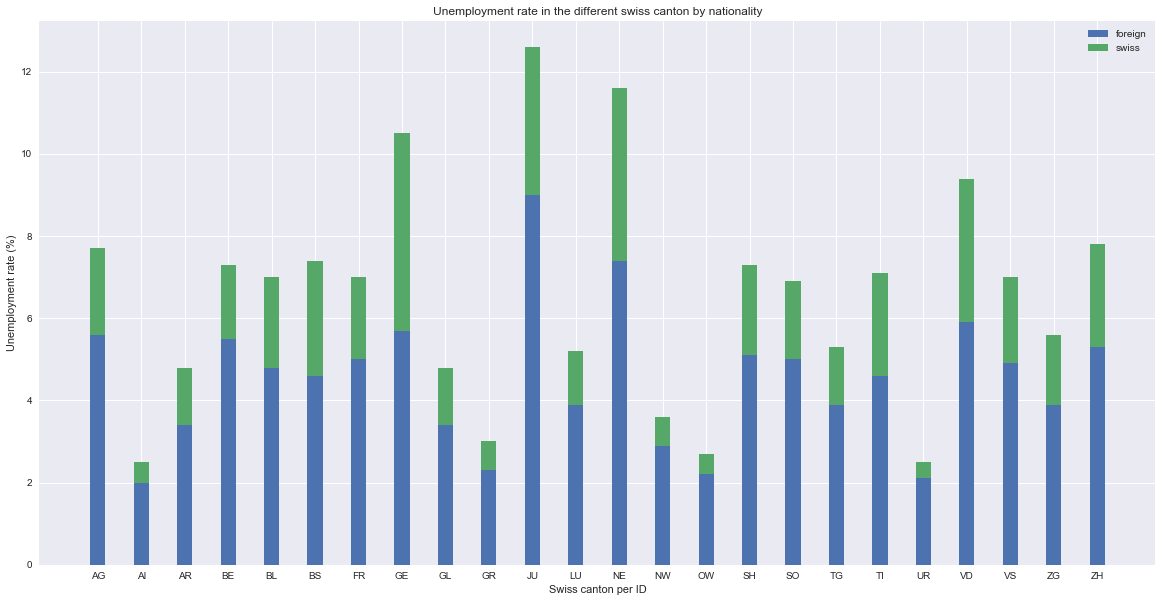

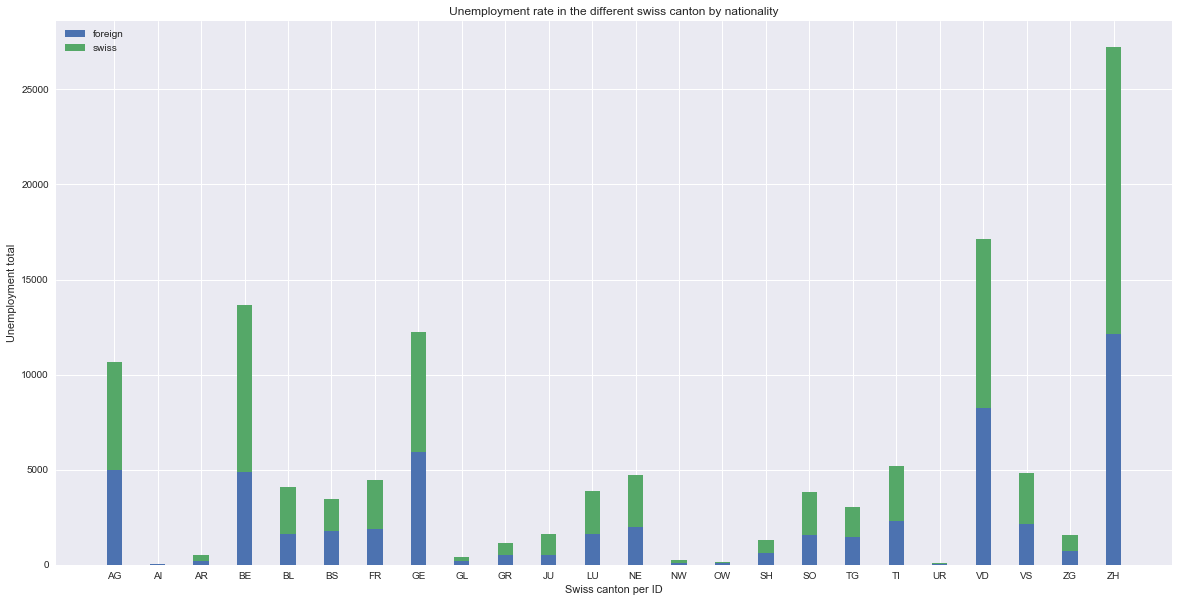

In [201]:
# rate of unemployment
plot_bar_graph_for_indexed_dataframe(un_swiss_foreign_indexed_df, column="rate")
# total unemployment
plot_bar_graph_for_indexed_dataframe(un_swiss_foreign_indexed_df, column="total")

#### Swiss unemployment by age

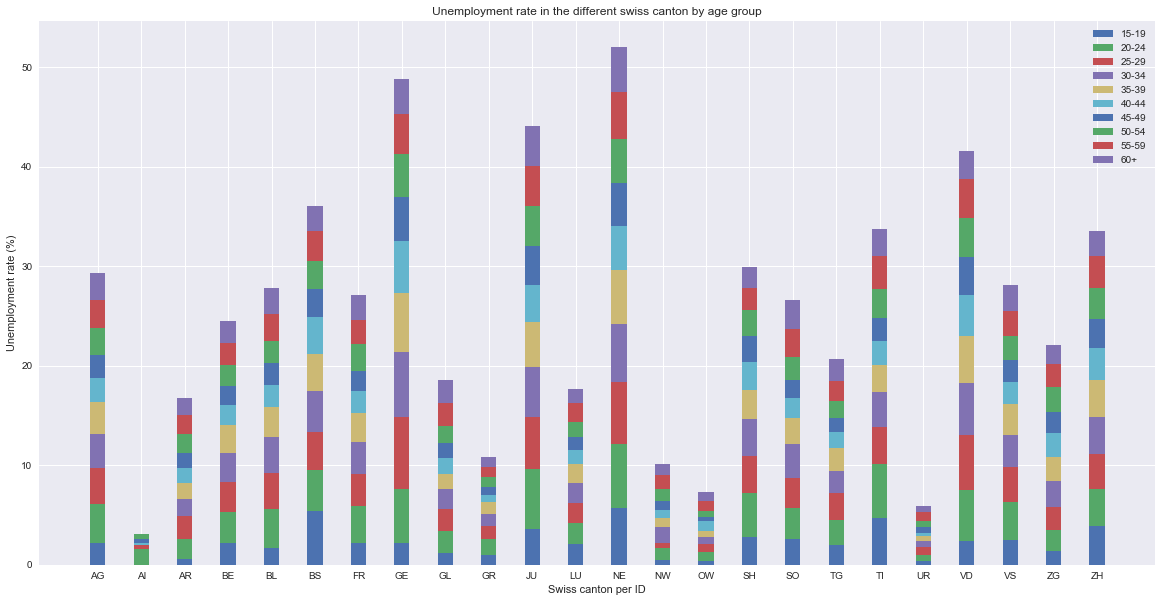

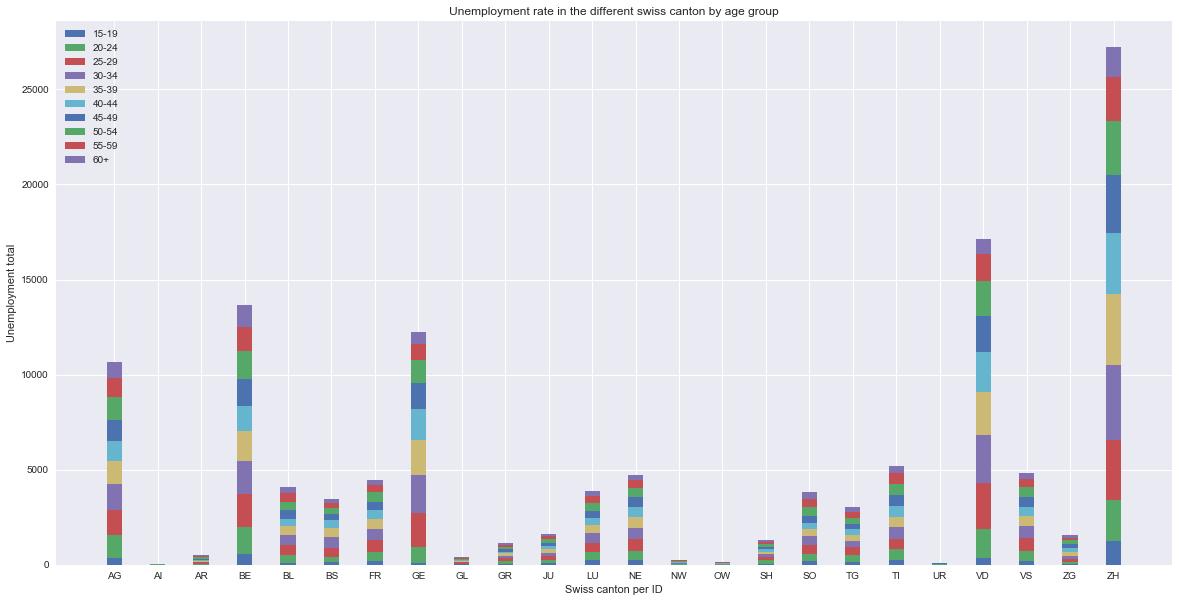

In [202]:
# rate of unemployment
plot_bar_graph_for_indexed_dataframe(un_swiss_age_indexed_df, column="rate", append_title="age group")
# total unemployment
plot_bar_graph_for_indexed_dataframe(un_swiss_age_indexed_df, column="total", append_title="age group")


### Generate an interactive bar plot (Optional: only available in jupyter notebook)

In [203]:
# Note: This section of code will not be properly displayed unless runned in a jupyter notebook
#       All the necessary data is given above, but the widget usage provide a nice way to visualize the data

In [204]:
def generate_interactive_bar_plot(dataset="nationality", ratio=True):
    """This function wraps the bar plot genarator so it can be easily called from an interactive widget
    
        @param dataset: The dataset to be used, one of: ["nationality", "age"]
        @param ratio: If true, the unemployment rate will be printed, otherwise the total
    """
    if ratio:
        column = "rate"
    else:
        column = "total"
        
    if dataset == "nationality":
        plot_bar_graph_for_indexed_dataframe(un_swiss_foreign_indexed_df, column, append_title="nationality") 
    elif dataset == "age":
        plot_bar_graph_for_indexed_dataframe(un_swiss_age_indexed_df, column, append_title="age")        
    else:
        print("ERROR: {} is not a supported dataset".format(dataset))
        raise

In [205]:
interact(generate_interactive_bar_plot,
         dataset=["nationality", "age"],
         ratio=True)

A Jupyter Widget

<function __main__.generate_interactive_bar_plot>

### Lets merge the information representations (Optional: only available in jupyter notebook)

In [206]:
# Note: This section of code will not be properly displayed unless runned in a jupyter notebook
#       All the necessary data is given above, but the widget usage provide a nice way to visualize the data

This is not absolutely necessary, but it is nice to show how we could create a complex interface through one widget

In [207]:
def interactive_multi_interface(interface="map"):
    if interface == "map":
        interact(generate_interactive_map,
                 dataset=["global", "nationality", "age"])
    elif interface == "bar":
        interact(generate_interactive_bar_plot,
                 dataset=["nationality", "age"],
                 ratio=True)
    else:
        print("ERROR: {} is not a valid interface!".format(interface))
        raise

In [208]:
interact(interactive_multi_interface,
         interface=["map", "bar"])

A Jupyter Widget

<function __main__.interactive_multi_interface>